# Fase de Modelación

## Importaciones y setup:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shap
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import multiprocessing
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as st
seed = 42

In [2]:
dm = pd.read_json("modellingData.json")
dm.head()

,Metros Cuadrados,Estrato,Latitud,Longitud,Antigüedad (Grupo),Dormitorios (bedrooms),Baños,Parqueaderos,Fecha de Creacion de Oferta,Fecha de Actualización de Oferta,Precio,tipo_Apartamento,tipo_Casa,ciudad_Bello,ciudad_Envigado,ciudad_Itaguí,ciudad_La estrella,ciudad_Medellín,ciudad_Sabaneta
0,59.0,3,6.343308,-75.542227,2,3,2.0,0,1756080000000,1757980800000,275000000,True,False,True,False,False,False,False,False
1,64.9,3,6.340643,-75.560242,2,0,2.0,0,1756425600000,1756425600000,280000000,True,False,True,False,False,False,False,False
2,67.0,3,6.341758,-75.578913,3,3,2.0,1,1756944000000,1761782400000,260000000,True,False,True,False,False,False,False,False
3,72.0,3,6.340513,-75.539474,2,3,2.0,1,1757030400000,1758326400000,433000000,True,False,True,False,False,False,False,False
4,91.0,3,6.335474,-75.555586,4,3,2.0,0,1757376000000,1759104000000,295000000,False,True,True,False,False,False,False,False


In [3]:
dm['Precio'].describe()

# Note que precio tiene una cola derecha significativamente grande, donde la media es más grande que la mediana.

count    5.129000e+03
mean     5.640331e+08
std      3.258676e+08
min      1.020000e+08
25%      3.400000e+08
50%      4.700000e+08
75%      6.900000e+08
max      2.000000e+09
Name: Precio, dtype: float64

### Matriz de Correlación

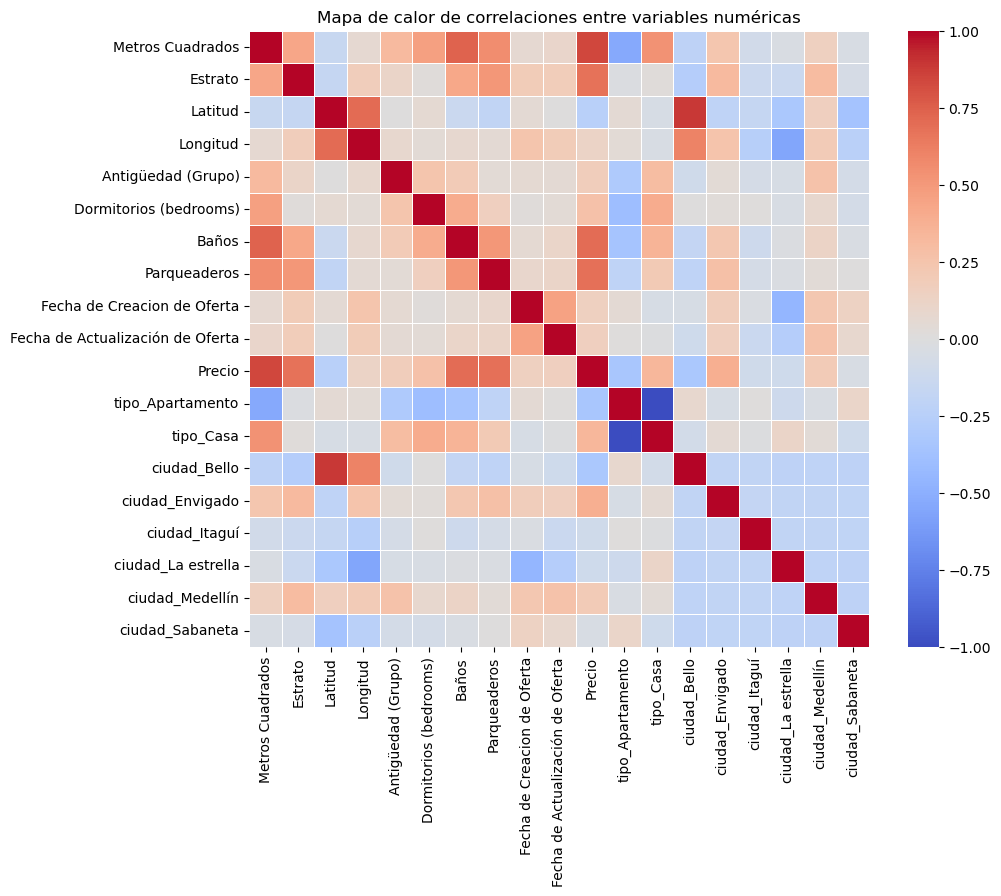

In [4]:
corr = dm.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=False,          # muestra los valores numéricos
            fmt=".2f",           # formato de decimales
            cmap="coolwarm",     # paleta de colores
            center=0,            # centra el color en 0 (rojo-negativo, azul-positivo)
            linewidths=0.5)

plt.title("Mapa de calor de correlaciones entre variables numéricas")
plt.show()

La matriz de correlación de pearson nos muestra el impacto de una variable en otra. Por ejemplo, podemos ver que la latitud cambia al ver las dummies de ciudad (viendo que Bello este en el norte y Sabaneta en el sur). Así mismo analizamos que los baños y los parqueaderos son métricas importantes en el precio. Vemos que las casas en Envigado y Medellín son más caras que en el resto de ciudades del área metropolitana.  

## Análisis de importancia

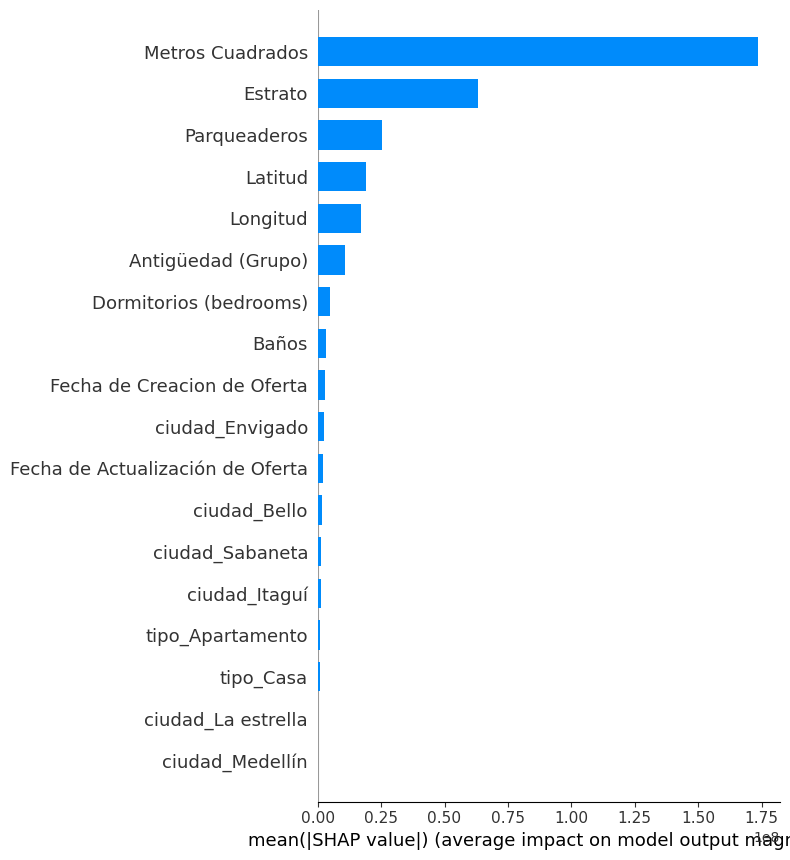

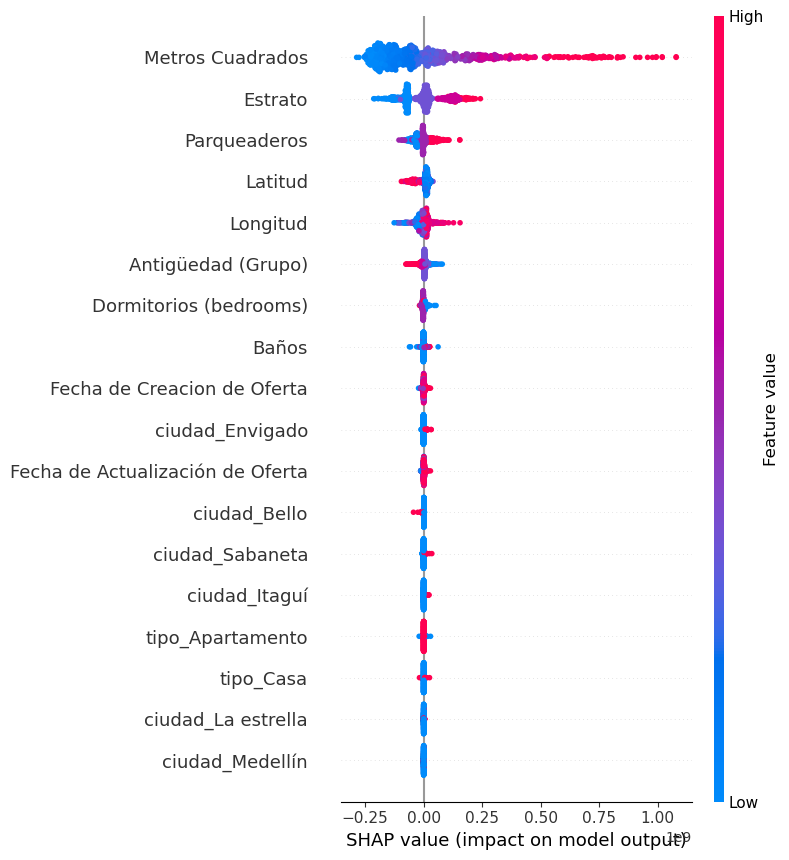

In [5]:
X = dm.drop(columns=["Precio"]) 
y = dm["Precio"]

#Separar train y test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 
model = RandomForestRegressor(n_estimators=200, random_state=seed)
model.fit(X_train, y_train)


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.summary_plot(shap_values, X_test)

### Análisis en los valores SHAP
Vemos que el análisis de SHAP con un modelo de RandomForest nos brinda información muy valiosa, dado que los valores más importantes en afectar el precio son los metros cuadrados de la casa, su estrato, su cantidad de parqueaderos, su ubicación y su antigüedad.

## División de datos (todas las variables)

In [6]:
# 80 10 10

X = dm.drop(columns=["Precio"])
y = dm["Precio"]


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.11111, random_state=42
)  


print("Tamaños de los conjuntos:")
print(f"Entrenamiento: {len(X_train)} ({len(X_train)/len(dm)*100:.1f}%)")
print(f"Validación:    {len(X_val)} ({len(X_val)/len(dm)*100:.1f}%)")
print(f"Prueba:        {len(X_test)} ({len(X_test)/len(dm)*100:.1f}%)")


Tamaños de los conjuntos:
Entrenamiento: 4103 (80.0%)
Validación:    513 (10.0%)
Prueba:        513 (10.0%)


## Entrenamiento, Validación y Prueba

In [8]:
np.random.seed(42)

param_grid_dt = {
    "max_depth": np.random.randint(2, 20, 75),
    "min_samples_split": np.random.randint(2, 10, 75),
    "criterion": 'absolute_error'
}

param_grid_rf = {
    "n_estimators": np.random.randint(50, 75, 300),
    "max_depth": np.random.randint(5, 25, 75),
    "min_samples_split": np.random.randint(2, 10, 75),
    "criterion": 'absolute_error'
}

param_grid_gb = {
    "n_estimators": np.random.randint(50, 75, 300),
    "learning_rate": np.random.uniform(0.01, 0.2, 75),
    "max_depth": np.random.randint(2, 10, 75), 
    "criterion": 'absolute_error'
}

resultados = []

for i in range(75):
    dt = DecisionTreeRegressor(
        criterion='absolute_error',
        max_depth=param_grid_dt["max_depth"][i],
        min_samples_split=param_grid_dt["min_samples_split"][i],
        random_state=42
    )
    dt.fit(X_train, y_train)
    pred_dt = dt.predict(X_val)
    resultados.append({
        "modelo": "DecisionTree",
        "iter": i + 1,
        "max_depth": param_grid_dt["max_depth"][i],
        "min_samples_split": param_grid_dt["min_samples_split"][i],
        "MAE": mean_absolute_error(y_val, pred_dt),
        "MAPE": mean_absolute_percentage_error(y_val, pred_dt),
        "MSE": mean_squared_error(y_val, pred_dt)
    })
    rf = RandomForestRegressor(
        n_estimators=param_grid_rf["n_estimators"][i],
        criterion='absolute_error',
        max_depth=param_grid_rf["max_depth"][i],
        min_samples_split=param_grid_rf["min_samples_split"][i],
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_val)
    resultados.append({
        "modelo": "RandomForest",
        "iter": i + 1,
        "n_estimators": param_grid_rf["n_estimators"][i],
        "max_depth": param_grid_rf["max_depth"][i],
        "min_samples_split": param_grid_rf["min_samples_split"][i],
        "MAE": mean_absolute_error(y_val, pred_rf),
        "MAPE": mean_absolute_percentage_error(y_val, pred_rf),
        "MSE": mean_squared_error(y_val, pred_rf)
    })
    gb = GradientBoostingRegressor(
        n_estimators=param_grid_gb["n_estimators"][i],
        learning_rate=param_grid_gb["learning_rate"][i],
        max_depth=param_grid_gb["max_depth"][i],
        random_state=42
    )
    gb.fit(X_train, y_train)
    pred_gb = gb.predict(X_val)
    resultados.append({
        "modelo": "GradientBoosting",
        "iter": i + 1,
        "n_estimators": param_grid_gb["n_estimators"][i],
        "learning_rate": param_grid_gb["learning_rate"][i],
        "max_depth": param_grid_gb["max_depth"][i],
        "MAE": mean_absolute_error(y_val, pred_gb),
        "MAPE": mean_absolute_percentage_error(y_val, pred_gb),
        "MSE": mean_squared_error(y_val, pred_gb)
    })

resultados_df = pd.DataFrame(resultados).sort_values(by="MAE", ascending = False).reset_index(drop=True)

print("\n Mejores modelos encontrados (ordenados por MAE):")
print(resultados_df.head(1))
print(print("\n Mejores modelos encontrados (ordenados por MSE):"))
print(resultados_df.sort_values(by = "MSE").reset_index(drop=True).head(1))  
print("\n Mejores modelos encontrados (ordenados por MAPE):")
print(resultados_df.sort_values(by = "MAPE").reset_index(drop=True).head(1))


 Mejores modelos encontrados (ordenados por MAE):
             modelo  iter  max_depth  min_samples_split           MAE  \
0  GradientBoosting    58          7                NaN  6.522512e+07   

       MAPE           MSE  n_estimators  learning_rate  
0  0.120799  1.024206e+16          59.0       0.163114  

 Mejores modelos encontrados (ordenados por MSE):
None
             modelo  iter  max_depth  min_samples_split           MAE  \
0  GradientBoosting    58          7                NaN  6.522512e+07   

       MAPE           MSE  n_estimators  learning_rate  
0  0.120799  1.024206e+16          59.0       0.163114  

 Mejores modelos encontrados (ordenados por MAPE):
             modelo  iter  max_depth  min_samples_split           MAE  \
0  GradientBoosting    58          7                NaN  6.522512e+07   

       MAPE           MSE  n_estimators  learning_rate  
0  0.120799  1.024206e+16          59.0       0.163114  


Encontramos que los tres mejores modelos para las tres métricas (MAE (Mean Absolute Error), MSE(Mean Squared Error) y MAPE (Mean Absoluto Percentage Error)) son versiones del GradientBoosting y del RandomForest. Para hacer la ejecución de manera más rápida usamos la ejecución en paralelo, aprovechando todos los núcleos del procesador. 

### ¿Cual es la mejor métrica?
Consideramos que la métrica correcta es el MAE, esto es debido a que el MSE es muy penalizador ante errores muy grandes, y el MAPE puede ser engañoso para rangos muy grandes de precios, como en este conjunto de datos. Por ende, se escoge el modelo Gradient Boosting con 9  de profundidad máxima, 74  estimadores y criterio de minimización el error absoluto

In [15]:
resultados_df.iloc[0]

modelo                  GradientBoosting
iter                                  58
max_depth                              7
min_samples_split                    NaN
MAE                      65225118.125304
MAPE                            0.120799
MSE                  10242059102360638.0
n_estimators                        59.0
learning_rate                   0.163114
Name: 0, dtype: object

In [30]:
lista_modelo = resultados_df.iloc[0].to_list()
lista_modelo

['GradientBoosting',
 np.int64(58),
 np.int32(7),
 np.float64(nan),
 np.float64(65225118.125304),
 np.float64(0.120798982438735),
 np.float64(1.0242059102360638e+16),
 np.float64(59.0),
 np.float64(0.16311432848081725)]

In [47]:
float(lista_modelo[7])

59.0

In [48]:
model = GradientBoostingRegressor(
        n_estimators= int(lista_modelo[7]),
        max_depth= int(lista_modelo[2]),
        random_state=42,
        learning_rate = float(lista_modelo[8])
)


model = model.fit(X_train, y_train)
pred_val = model.predict(X_val)
pred_test = model.predict(X_test)

In [49]:
mae = mean_absolute_error(y_val, pred_val)
mse = mean_squared_error(y_val, pred_val)
mape = mean_absolute_percentage_error(y_val, pred_val)

In [50]:
print("Metricas en validación Modelo Escogido: ")
print("MSE: " +  str(mse))
print("MAE: " + str(mae))
print("MAPE: "+ str(mape))

Metricas en validación Modelo Escogido: 
MSE: 1.0242059102360638e+16
MAE: 65225118.125304
MAPE: 0.120798982438735


## Evaluación

### Validación:
Primero validaremos si las métricas del conjunto de validación son similares a las métricas del conjunto de prueba.


In [ ]:
pred_val = model.predict(X_val)
pred_test = model.predict(X_test)

In [ ]:
def evaluar(y, y_eval):
    mae = mean_absolute_error(y, y_eval)
    mse = mean_squared_error(y, y_eval)
    mape = mean_absolute_percentage_error(y, y_eval)
    return mae, mse, mape

In [ ]:
mae_val, mse_val, mape_val = evaluar(y_val, pred_val)
mae_test, mse_test, mape_test = evaluar(y_test, pred_test)

In [ ]:
print(f"Validación -> MAE: {mae_val:,.0f}  | RMSE: {mse_val:,.0f}  | MAPE: {mape_val*100:.2f}%")
print(f"Prueba      -> MAE: {mae_test:,.0f}  | RMSE: {mse_test:,.0f}  | MAPE: {mape_test*100:.2f}%")

diff = abs(mae_val - mae_test) / mae_val

print("Diagnóstico:")
if diff < 0.10:
    print(" No hay indicios de overfitting. El modelo generaliza bien.")
elif diff < 0.25:
    print("Diferencias moderadas: puede haber un leve sobreajuste, pero aceptable.")
else:
    print(" Posible overfitting: el modelo funciona mucho mejor en validación que en prueba.")

### Distribución del error para nuestro modelo escogido

Ahora que vimos que nuestro modelo generaliza bien, veamos cómo se distribuye el error, es decir para que rangos específicos de precio es mas preciso el modelo.

In [ ]:
err_abs = abs(y_test - pred_test)
err_abs

In [ ]:
dm_test = dm.loc[dm.index.isin(X_test.index)].copy()
dm_test.loc[:, "Error absoluto"] = np.ravel(err_abs)

dm_test.head()


#### Distribución del error

In [ ]:
mae_value = dm_test["Error absoluto"].mean()

plt.figure(figsize=(8,6))
sns.histplot(dm_test["Error absoluto"], bins=50, kde=True, color="steelblue", alpha=0.7)
plt.axvline(0, color="black", linestyle="--", lw=1.5, label="Error = 0")
plt.axvline(mae_value, color="red", linestyle="--", lw=1.5, label=f"MAE = {mae_value:,.0f}")
plt.axvline(-mae_value, color="red", linestyle="--", lw=1.5)
plt.title("Distribución del Error con bandas del MAE", fontsize=14, fontweight="bold")
plt.xlabel("Error (Precio real − Predicho) [COP]", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
bins = [0, 200e6, 300e6, 400e6, 600e6]
labels = ["100-200M","200–300M", "300–400M", "400M+"]

# --- Crear columna de rango de precios ---
dm_plot = dm_test.copy()
dm_plot["Rango de Precio"] = pd.cut(dm_plot["Precio"], bins=bins, labels=labels, include_lowest=True)

# --- Calcular el MAE promedio por rango ---
mae_por_rango = dm_plot.groupby("Rango de Precio")["Error absoluto"].mean().reset_index()

# --- Graficar ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=mae_por_rango,
    x="Rango de Precio",
    y="Error absoluto",
    palette="crest"
)
plt.title("MAE promedio por rango de precio", fontsize=14, fontweight="bold")
plt.xlabel("Rango de precio (COP)", fontsize=12)
plt.ylabel("MAE (Error absoluto medio en COP)", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Distribución del error para grupos de ciudades

In [ ]:

ciudades = ["ciudad_Bello", "ciudad_Envigado", "ciudad_Itaguí",
            "ciudad_La estrella", "ciudad_Medellín", "ciudad_Sabaneta"]


dm_test_ciudades = dm_test.copy()
dm_test_ciudades["Ciudad"] = dm_test_ciudades[ciudades].idxmax(axis=1).str.replace("ciudad_", "")


mae_ciudad = dm_test_ciudades.groupby("Ciudad")["Error absoluto"].median().sort_values()


plt.figure(figsize=(9,6))
sns.barplot(x=mae_ciudad.index, y=mae_ciudad.values, palette="viridis")
plt.title("MAE promedio por ciudad", fontsize=14, fontweight="bold")
plt.ylabel("Error absoluto medio (COP)", fontsize=12)
plt.xlabel("Ciudad", fontsize=12)
plt.xticks(rotation=30)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Observamos que la ciudade de Sabaneta tienen un mayor MAE. Al inversionista le convendría mas no buscar en Sabaneta.

#### Distribución de errores por Estrato

In [ ]:
mae_estrato = dm_test.groupby("Estrato")["Error absoluto"].median().sort_index()

plt.figure(figsize=(8,6))
sns.barplot(x=mae_estrato.index, y=mae_estrato.values, palette="coolwarm")
plt.title("MAE promedio por estrato", fontsize=14, fontweight="bold")
plt.xlabel("Estrato socioeconómico", fontsize=12)
plt.ylabel("Error absoluto medio (COP)", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Mientras las casas mas caras se ponen, mas aumenta el MAE. 

#### Distribución de errores por grupo de antigüedad

In [ ]:
mae_antiguedad = (
    dm_test.groupby("Antigüedad (Grupo)")["Error absoluto"]
    .median()
    .sort_index()
)

mae_antiguedad.index = mae_antiguedad.index.astype(str)

plt.figure(figsize=(8,6))
sns.barplot(
    x=mae_antiguedad.index,
    y=mae_antiguedad.values,
    palette="crest"
)

plt.title("MAE promedio por grupo de antigüedad", fontsize=14, fontweight="bold")
plt.xlabel("Antigüedad (Grupo)", fontsize=12)
plt.ylabel("Error absoluto medio (COP)", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

#### Distribución de errores por metros cuadrados

In [ ]:

# --- 1️⃣ Crear categorías (bins) de tamaño ---
bins = [0, 50, 100, 150, 200, 300]
labels = ["0-50", "51-100", "101-150", "151-200", "201-300"]

dm_test = dm_test.copy()
dm_test["Rango Metros Cuadrados"] = pd.cut(dm_test["Metros Cuadrados"], bins=bins, labels=labels, include_lowest=True)

# --- 2️⃣ Calcular MAE promedio por rango ---
mae_m2 = dm_test.groupby("Rango Metros Cuadrados")["Error absoluto"].median()

# --- 3️⃣ Graficar ---
plt.figure(figsize=(10,6))
sns.barplot(x=mae_m2.index, y=mae_m2.values, palette="flare")
plt.title("MAE promedio por rango de Metros Cuadrados", fontsize=14, fontweight="bold")
plt.xlabel("Rango de área (m²)", fontsize=12)
plt.ylabel("Error absoluto medio (COP)", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


Es preferible usar el modelo para casas entre los 50 y 100 m2 o entre 150 y 200 m2. 

#### Distribución de errores por tipo de vivienda

In [ ]:
viviendas = ["tipo_Casa", "tipo_Apartamento"]


dm_test_viviendas = dm_test.copy()
dm_test_viviendas["Vivienda"] = dm_test_viviendas[viviendas].idxmax(axis=1).str.replace("tipo_", "")


mae_viviendas = dm_test_viviendas.groupby("Vivienda")["Error absoluto"].median().sort_values()


plt.figure(figsize=(9,6))
sns.barplot(x=mae_viviendas.index, y=mae_viviendas.values, palette="viridis")
plt.title("MAE promedio por tipo de  vivienda", fontsize=14, fontweight="bold")
plt.ylabel("Error absoluto medio (COP)", fontsize=12)
plt.xlabel("Ciudad", fontsize=12)
plt.xticks(rotation=30)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Son muy parecidos

#### Distribución de errores por precio

In [ ]:

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=dm_test,
    x="Precio",
    y="Error absoluto",
    alpha=0.4,
    color="royalblue"
)
plt.title("Relación entre Precio y Error Absoluto", fontsize=14, fontweight="bold")
plt.xlabel("Precio (COP)", fontsize=12)
plt.ylabel("Error absoluto (COP)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Análisis de confianza de las métricas

### Análisis de confianza paramétrico:

El error absoluto y Error son:

In [ ]:
err_abs

In [ ]:
err = (pred_test - y_test)
err

#### Histograma de los dos errores:

In [ ]:
DF = pd.DataFrame({'Residuos absolutos': err_abs})
ax = DF.plot.hist(bins=40, alpha=0.5, figsize=(16,4))

In [ ]:
DF = pd.DataFrame({'Residuos': err})
ax = DF.plot.hist(bins=40, alpha=0.5, figsize=(8,4))

In [ ]:
# El modelo está subestimando los precios reales.

In [ ]:
print(np.mean(err_abs))
print(np.median(err_abs))

Note que los valores de la media y mediana difieren por outliers, casi que uno es el doble del otro

### Test de normalidad y de Ljung-box

In [ ]:
k2, p = stats.normaltest(err)

print("Error: p  {:g}".format(p))

k2, p = stats.normaltest(err_abs)

print("Error absoluto p = {:g}".format(p))

Por supuesto que los errores no se distribuyen normal, pero igual hagamos los tests, y despues encontramos intervalos de confianza no paramétricos

In [ ]:
ljung_err = acorr_ljungbox(err, lags=[10], return_df=True)  # prueba hasta el lag 10
ljung_abs = acorr_ljungbox(err_abs, lags=[10], return_df=True)

print("Test de Ljung–Box para errores (err):")
print(ljung_err)
print("Test de Ljung–Box para errores absolutos (err_abs):")
print(ljung_abs)

Los errores son independientes, no hay autocorrelación

### Intervalos de confianza del MAE, MSE y MAPE

In [ ]:
n = len(err_abs)
mae_sample = np.mean(err_abs)
std_err = np.std(err_abs, ddof=1) / np.sqrt(n)  # error estándar de la media

# --- Intervalo de confianza 95% (
conf_level = 0.95
z = st.norm.ppf(1 - (1 - conf_level) / 2)
ci_lower = mae_sample - z * std_err
ci_upper = mae_sample + z * std_err

print(f"Intervalo de confianza del {conf_level*100:.0f}% para el MAE (asumiendo normalidad):")
print(f"MAE estimado: {mae_sample:,.0f}")
print(f"IC: [{ci_lower:,.0f}, {ci_upper:,.0f}]")

In [ ]:


y_true = np.ravel(y_test)
y_pred = np.ravel(pred_test)
n = len(y_true)
if n == 0:
    raise ValueError("y_test vacío.")


conf_level = 0.95
alpha = 1 - conf_level


resid = y_true - y_pred
sq_err = resid**2
err_abs = np.abs(resid)


mse = sq_err.mean()            # MSE muestral
SSE = n * mse                  # suma de cuadrados del error

chi2_lower = st.chi2.ppf(alpha/2, df=n)         # cuantil bajo
chi2_upper = st.chi2.ppf(1 - alpha/2, df=n)     # cuantil alto

if chi2_lower <= 0:
    ci_mse_lower = np.nan
    ci_mse_upper = SSE / chi2_lower if chi2_lower != 0 else np.nan
else:
    
    ci_mse_lower = SSE / chi2_upper
    ci_mse_upper = SSE / chi2_lower

den = np.where(y_true == 0, np.nan, y_true)
ape = np.abs((y_true - y_pred) / den)   # proporción (ej. 0.10 = 10%)

valid_mask = ~np.isnan(ape)
n_map = valid_mask.sum()
if n_map == 0:
    raise ValueError("No hay observaciones válidas para MAPE (todos y_test == 0).")

ape_valid = ape[valid_mask]
mape = np.nanmean(ape_valid)                   # MAPE en proporción
se_mape = np.nanstd(ape_valid, ddof=1) / np.sqrt(n_map)
t_crit = st.t.ppf(1 - alpha/2, df=n_map - 1)
ci_mape_lower = mape - t_crit * se_mape
ci_mape_upper = mape + t_crit * se_mape

print(f"n (observaciones) = {n}")
print("\n--- MSE (paramétrico, asumiendo normalidad de residuos) ---")
print(f"MSE (muestral) = {mse:,.0f}")
if np.isnan(ci_mse_lower):
    print("IC MSE (χ²): rango inferior no definido (chi2_lower <= 0).")
else:
    print(f"IC {int(conf_level*100)}% para MSE: [{ci_mse_lower:,.0f}, {ci_mse_upper:,.0f}]")

print("\n--- MAPE (aprox. paramétrica por t-Student sobre APE) ---")
print(f"MAPE (proporción) = {mape:.4f}  (equiv. {mape*100:.2f} %)")
print(f"n válidas para MAPE = {n_map}")
print(f"IC {int(conf_level*100)}% para MAPE (proporción): [{ci_mape_lower:.4f}, {ci_mape_upper:.4f}]")
print(f"IC {int(conf_level*100)}% para MAPE (en %): [{ci_mape_lower*100:.2f}%, {ci_mape_upper*100:.2f}%]")



Con 95% de confianza:
El MAE se encuentra entre estos valores.

El MSE se encuentra entre estos valores.

El MAPE se encuentre entre estos valores.

### Intervalos de confianza no paramétricos

In [ ]:
y_true = np.ravel(y_test)
y_pred = np.ravel(pred_test)
n_boot = 5000
conf_level = 0.95
alpha = 1 - conf_level
rng = np.random.default_rng(42)


mae = np.mean(np.abs(y_true - y_pred))
mse = np.mean((y_true - y_pred) ** 2)
mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, np.nan, y_true)))

print(f"MAE:  {mae:,.0f}")
print(f"MSE:  {mse:,.0f}")
print(f"MAPE: {mape*100:.2f}%")

# --- Función general para bootstrap ---
def bootstrap_ci(stat_func, y_true, y_pred, n_boot=5000, conf_level=0.95, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)
    boot_stats = np.empty(n_boot)
    for i in range(n_boot):
        idx = rng.integers(0, n, n)
        boot_stats[i] = stat_func(y_true[idx], y_pred[idx])
    lower = np.percentile(boot_stats, 100 * (1 - conf_level) / 2)
    upper = np.percentile(boot_stats, 100 * (1 - (1 - conf_level) / 2))
    return lower, upper


mae_func  = lambda y, yhat: np.mean(np.abs(y - yhat))
mse_func  = lambda y, yhat: np.mean((y - yhat)**2)
mape_func = lambda y, yhat: np.nanmean(np.abs((y - yhat) / np.where(y==0, np.nan, y)))

ci_mae  = bootstrap_ci(mae_func,  y_true, y_pred, n_boot=n_boot, conf_level=conf_level)
ci_mse  = bootstrap_ci(mse_func,  y_true, y_pred, n_boot=n_boot, conf_level=conf_level)
ci_mape = bootstrap_ci(mape_func, y_true, y_pred, n_boot=n_boot, conf_level=conf_level)


print("Intervalos de confianza Bootstrap (percentil, 95%)")
print(f"MAE : [{ci_mae[0]:,.0f}, {ci_mae[1]:,.0f}]")
print(f"MSE : [{ci_mse[0]:,.0f}, {ci_mse[1]:,.0f}]")
print(f"MAPE: [{ci_mape[0]*100:.2f}%, {ci_mape[1]*100:.2f}%]")


Con 95% de confianza:

El MAE se encuentra entre estos valores.

El MSE se encuentra entre estos valores.

El MAPE se encuentre entre estos valores.

### Análisis de las métricas

El MAPE y el MAE tienen un desempeño bueno, sin embargo el MSE no es el mejor, debido a que algunos outliers penalizan mucho el valor de este. Bajo el MAE, consideramos que el rendimiento del modelo es bueno, especialmente para hogares pequeños y medianos, sin embargo en otros ensayos calculando las métricas, el modelo no tenía un buen desempeño con casas caras. Sería bueno poder observar con más datos aún como puede aprender el modelo más acerca de las áreas menos centradas del valle de aburrá, como de Bello y La Estrella. Además sería bueno encontrar datos de Barbosa, Girardota, Copacabana y Caldas. 

# Respuesta a algunas preguntas de negocio
1. ¿Cuánto cuesta en promedio una vivienda en el área metropolitana? 

2. ¿Cómo influye el tipo de vivienda en el precio de la venta? 

3. ¿Cuáles son las variables que más influyen en el precio de una vivienda? 

4. ¿Cómo afecta el precio de una casa dependiendo de la localidad? 

## Respuesta 1

In [ ]:
print("El precio de una casa en el area metropolitana es de ",dm['Precio'].mean().round(), "COP")

## Respuesta 2
Encontramos por la matriz de correlación que el tipo de vivienda influye, las casas suelen elevar el precio de la vivienda, mientras que los apartamentos lo reducen.

## Respuesta 3

Las variables que mas influyen en el precio de una vivienda son:
1. Sus metros cuadrados
2. Su estrato
3. Su cantidad de parqueaderos
4. Su latitud y Longitud
5. Su antiguedad.

## Respuesta 4
Encontramos que las casas en Medellín y Envigado afectan positivamente al precio, mientras que especialmente Bello la afecta negativamente. Los municipios de Sabaneta, La Estrella e Itaguí se encuentran más en la mitad.

Consideramos que se cumplió el objetivo de negocio, sin embargo esto únicamente es verdad para un sector específico del Valle de Aburrá. Al scrapear más datos seguramente se pueda reducir considerablemente el error, y el rendimiento que tiene el modelo. Se puede hacer además diferentes variaciones de los hiperparámetros.

In [ ]:
model_save = model.fit(X,y)

In [ ]:
import pickle as pk
pk.dump(model_save, open("modelo_final_escogido.pickle", "wb"))

Ya con esto, el modelo quedó guardado.